In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [2]:
data = pd.read_csv('apartments_for_rent_classified_100K.csv', sep=";", encoding='cp1252', low_memory=False)

In [3]:

#remove rows where id category title nad price are null 
data = data.dropna(subset=['id', 'category', 'title', 'price','price_type','fee','bedrooms','bathrooms','time','source','square_feet','state','latitude','longitude','amenities'])
#drop address and pets allowed columns
data = data.drop(columns=['address','pets_allowed','price_type'])
#remove rows where price is 0
data = data[data.price != 0]
data.head()
data.info()
data.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 83166 entries, 21 to 99491
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             83166 non-null  int64  
 1   category       83166 non-null  object 
 2   title          83166 non-null  object 
 3   body           83166 non-null  object 
 4   amenities      83166 non-null  object 
 5   bathrooms      83166 non-null  float64
 6   bedrooms       83166 non-null  float64
 7   currency       83166 non-null  object 
 8   fee            83166 non-null  object 
 9   has_photo      83166 non-null  object 
 10  price          83166 non-null  float64
 11  price_display  83166 non-null  object 
 12  square_feet    83166 non-null  int64  
 13  cityname       83166 non-null  object 
 14  state          83166 non-null  object 
 15  latitude       83166 non-null  float64
 16  longitude      83166 non-null  float64
 17  source         83166 non-null  object 
 18  time      

,id,bathrooms,bedrooms,price,square_feet,latitude,longitude,time
count,8.316600e+04,83166.000000,83166.000000,83166.000000,83166.000000,83166.000000,83166.000000,8.316600e+04
mean,5.344127e+09,1.443078,1.716098,1517.500300,949.264519,36.882695,-91.285278,1.558824e+09
std,1.807414e+08,0.534653,0.721627,902.832149,338.299885,4.584125,15.720284,1.087552e+07
min,5.121046e+09,1.000000,0.000000,100.000000,130.000000,19.573800,-159.369800,1.544174e+09
25%,5.197908e+09,1.000000,1.000000,1010.000000,735.000000,33.731100,-104.768800,1.550829e+09
50%,5.198614e+09,1.000000,2.000000,1349.000000,900.000000,37.178300,-84.487600,1.550864e+09
75%,5.508970e+09,2.000000,2.000000,1780.000000,1110.000000,39.907100,-77.494800,1.568765e+09
max,5.669439e+09,9.000000,9.000000,52500.000000,12000.000000,64.833200,-68.778800,1.577391e+09


In [8]:
def create_region_feature(df):
    # Define regions with their states
    regions = {
        'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
        'Southeast': ['AL', 'AR', 'FL', 'GA', 'KY', 'LA', 'MS', 'NC', 'SC', 'TN', 'VA', 'WV'],
        'Midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
        'Southwest': ['AZ', 'NM', 'OK', 'TX'],
        'West': ['CO', 'ID', 'MT', 'NV', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
    }
    
    # Create a dictionary mapping states to regions
    state_to_region = {
        state: region
        for region, states in regions.items()
        for state in states
    }
    
    # Create new region column based on state
    df['region'] = df['state'].map(state_to_region)
    
    # Handle any states that might not be in our mapping (optional)
    df['region'] = df['region'].fillna('Other')
    
    return df

# Apply the transformation to your dataframe
data = create_region_feature(data)

# Verify the results
print("\nUnique regions:", data['region'].unique())
print("\nRegion distribution:")
print(data['region'].value_counts())

# Optional: Create dummy variables for regions if needed for modeling
region_dummies = pd.get_dummies(data['region'], prefix='region')
data = pd.concat([data, region_dummies], axis=1)



Unique regions: ['Southwest' 'West' 'Midwest' 'Southeast' 'Northeast' 'Other']

Region distribution:
region
Southeast    25680
West         16817
Southwest    12122
Midwest       9948
Northeast     8981
Other         4565
Name: count, dtype: int64
region
Southeast    25680
West         16817
Southwest    12122
Midwest       9948
Northeast     8981
Other         4565
Name: count, dtype: int64


In [7]:
#remove outliners from price using iqr
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data['price'] < (Q1 - 1.5 * IQR)) | (data['price'] > (Q3 + 1.5 * IQR)))]
data.head()
data.info()
data.describe()
data
#show mean,median,mode,min,max,avg, std of price like mean : 455454 , median : 454545, mode : 454545, min : 454545, max : 454545, avg : 454545, std : 454545
mean = data['price'].mean()
median = data['price'].median()
mode = data['price'].mode()
min = data['price'].min()
max = data['price'].max()
avg = data['price'].mean()
std = data['price'].std()
print(f'mean : {mean} , median : {median}, mode : {mode}, min : {min}, max : {max}, avg : {avg}, std : {std}')


<class 'pandas.core.frame.DataFrame'>
Index: 78113 entries, 21 to 99491
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                78113 non-null  int64  
 1   category          78113 non-null  object 
 2   title             78113 non-null  object 
 3   body              78113 non-null  object 
 4   amenities         78113 non-null  object 
 5   bathrooms         78113 non-null  float64
 6   bedrooms          78113 non-null  float64
 7   currency          78113 non-null  object 
 8   fee               78113 non-null  object 
 9   has_photo         78113 non-null  object 
 10  price             78113 non-null  float64
 11  price_display     78113 non-null  object 
 12  square_feet       78113 non-null  int64  
 13  cityname          78113 non-null  object 
 14  state             78113 non-null  object 
 15  latitude          78113 non-null  float64
 16  longitude         78113 non-null  float64
 1

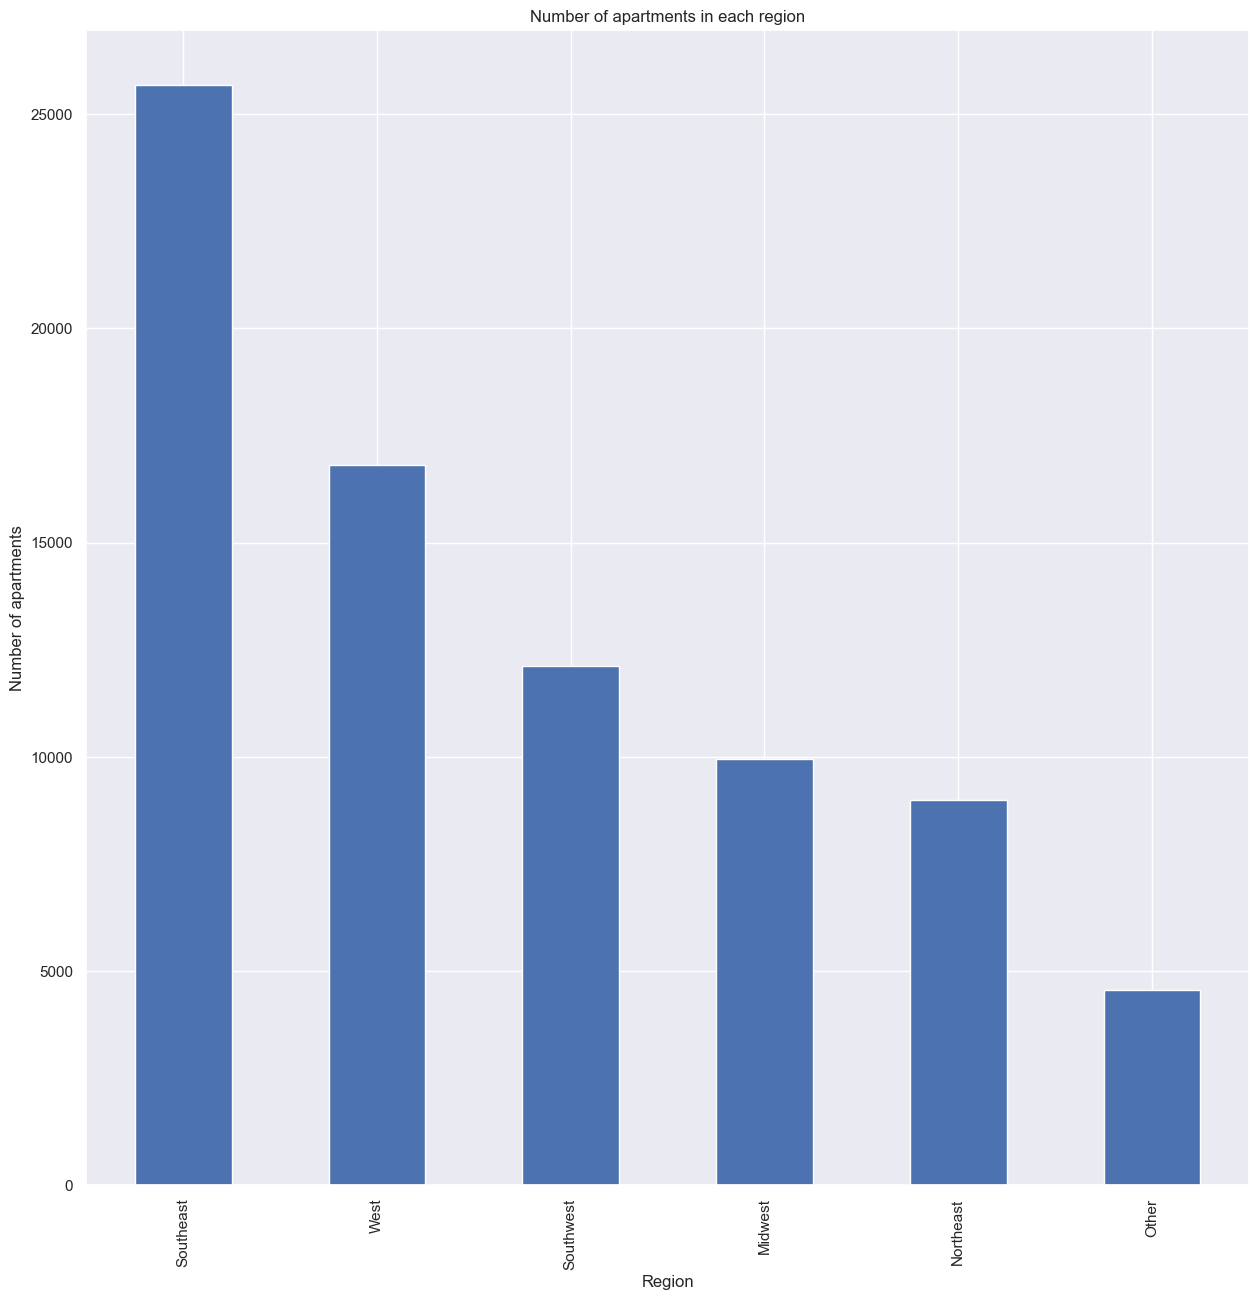

In [10]:
#show the number of apartments in each region
data['region'].value_counts().plot(kind='bar')
plt.title('Number of apartments in each region')
plt.xlabel('Region')
plt.ylabel('Number of apartments')
plt.show()


Mean Squared Error: 217764.8362095543
R^2: 0.10222752644248034


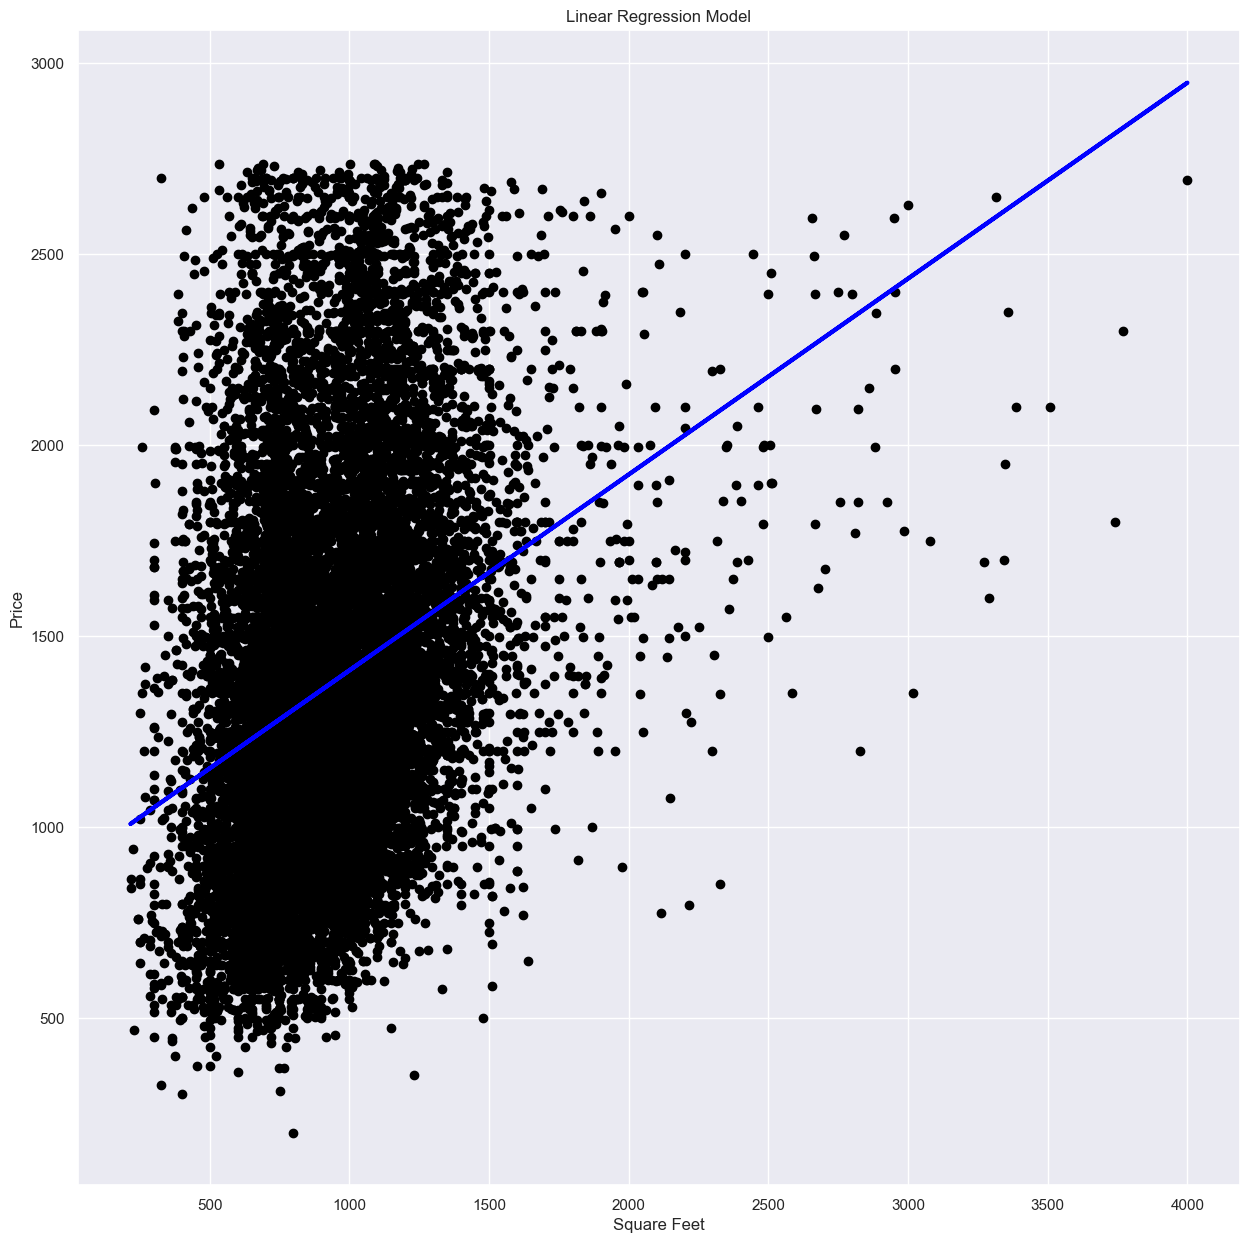

In [14]:
#run linear regression on square feet and price 
X = data[['square_feet']]
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#and show results
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2: {r2}')

#show it on graph
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('Square Feet')
plt.ylabel('Price')
plt.title('Linear Regression Model')
plt.show()



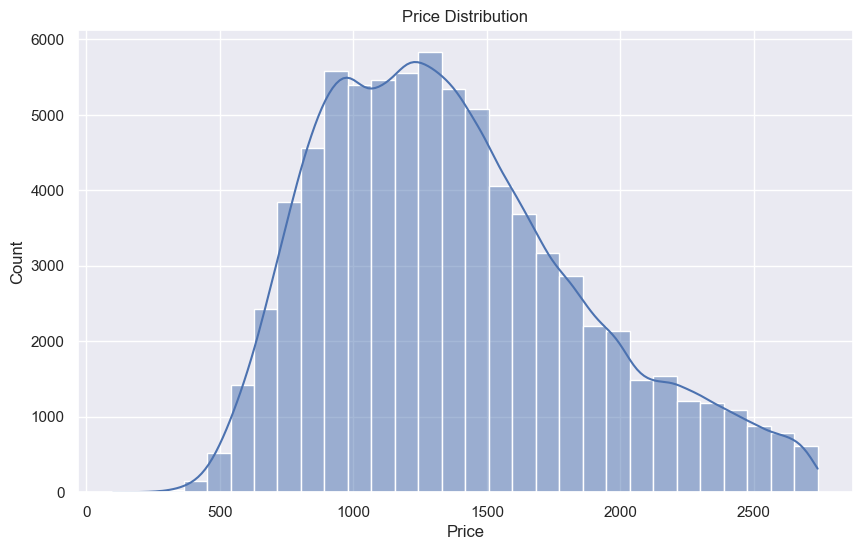

In [15]:
#show price distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


Mean Squared Error: 217191.34926429976
R^2: 0.10459182364654629


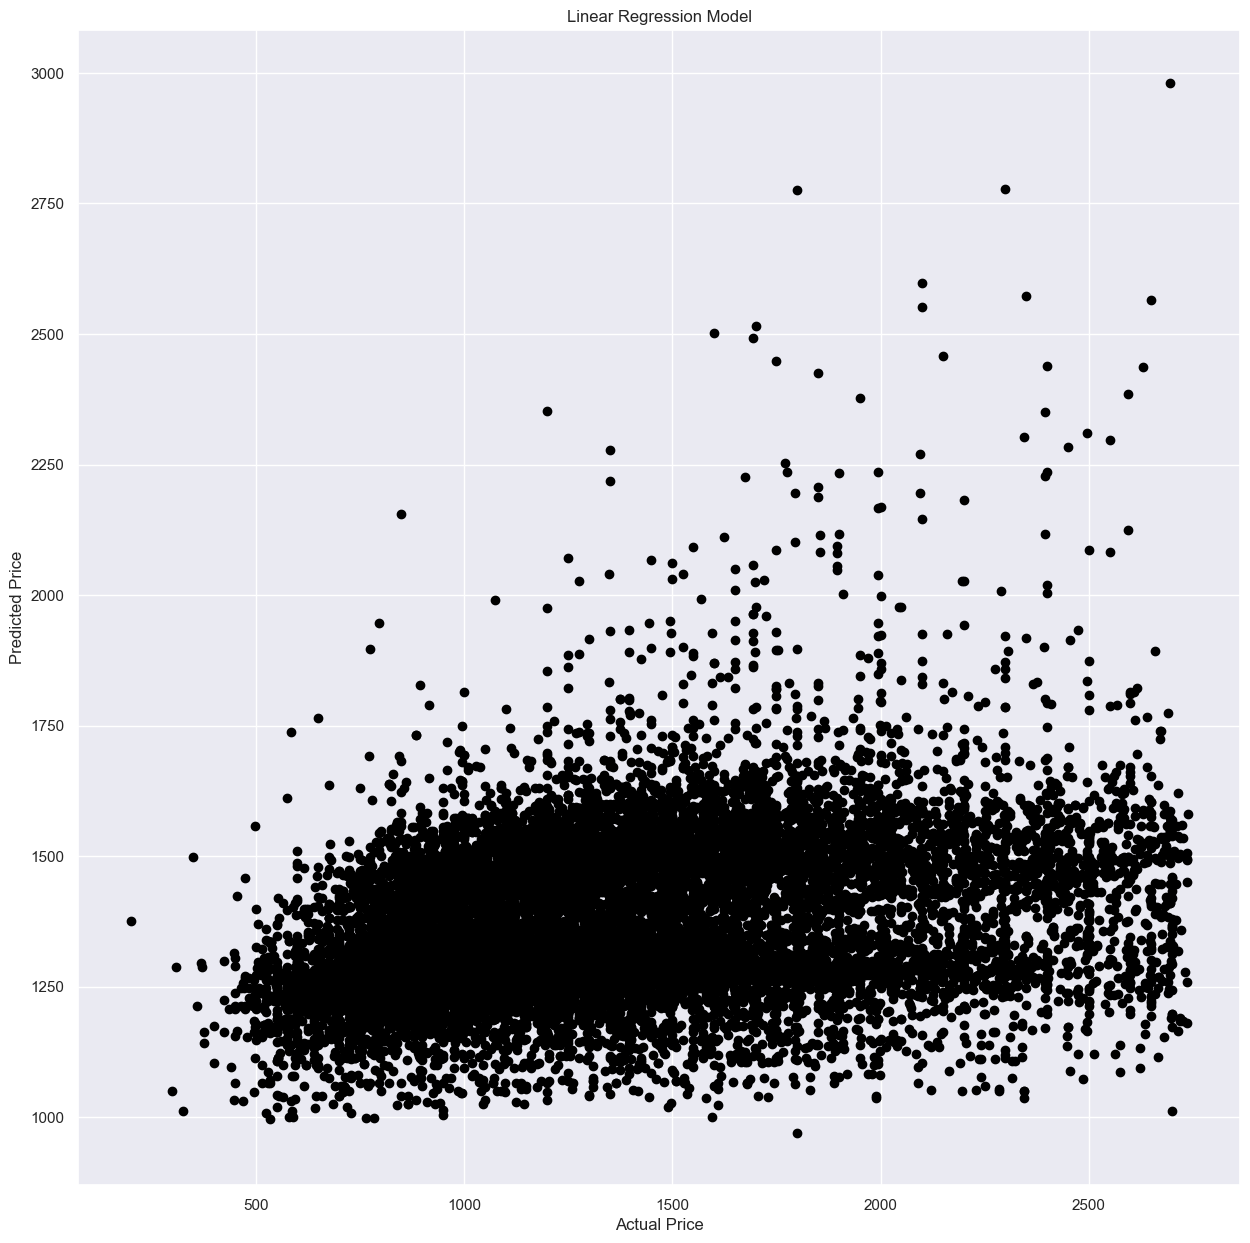

In [16]:
#run linear regression on price prediction with bedroom bathroom and square feet
X = data[['bedrooms', 'bathrooms', 'square_feet']]
y = data['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2: {r2}')
#show it on graph
plt.scatter(y_test, y_pred, color='black')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression Model')
plt.show()


In [17]:
#scale the numerical data with standard scaler
scaler = StandardScaler()
data[['bedrooms', 'bathrooms', 'square_feet','price']] = scaler.fit_transform(data[['bedrooms', 'bathrooms', 'square_feet','price']])
data.head()
data.describe()


,id,bathrooms,bedrooms,price,square_feet,latitude,longitude,time
count,7.811300e+04,7.811300e+04,7.811300e+04,78113.000000,7.811300e+04,78113.000000,78113.000000,7.811300e+04
mean,5.342090e+09,1.058814e-16,-1.477246e-16,1373.900913,-1.102477e-16,36.859707,-90.943047,1.558711e+09
std,1.805427e+08,1.000006e+00,1.000006e+00,491.390360,1.000006e+00,4.574894,15.195256,1.085339e+07
min,5.121046e+09,-8.125198e-01,-2.414021e+00,100.000000,-2.692095e+00,19.573800,-159.369800,1.544174e+09
25%,5.197908e+09,-8.125198e-01,-9.841661e-01,995.000000,-6.779306e-01,33.679500,-98.560300,1.550829e+09
50%,5.198602e+09,-8.125198e-01,4.456891e-01,1300.000000,-1.111305e-01,37.138600,-84.478300,1.550863e+09
75%,5.508969e+09,1.141646e+00,4.456891e-01,1675.000000,5.805006e-01,39.865200,-77.639000,1.568764e+09
max,5.669439e+09,8.958307e+00,6.165110e+00,2739.000000,3.735503e+01,64.833200,-68.778800,1.577391e+09


Mean Squared Error: 217191.34926429964
R^2: 0.10459182364654673


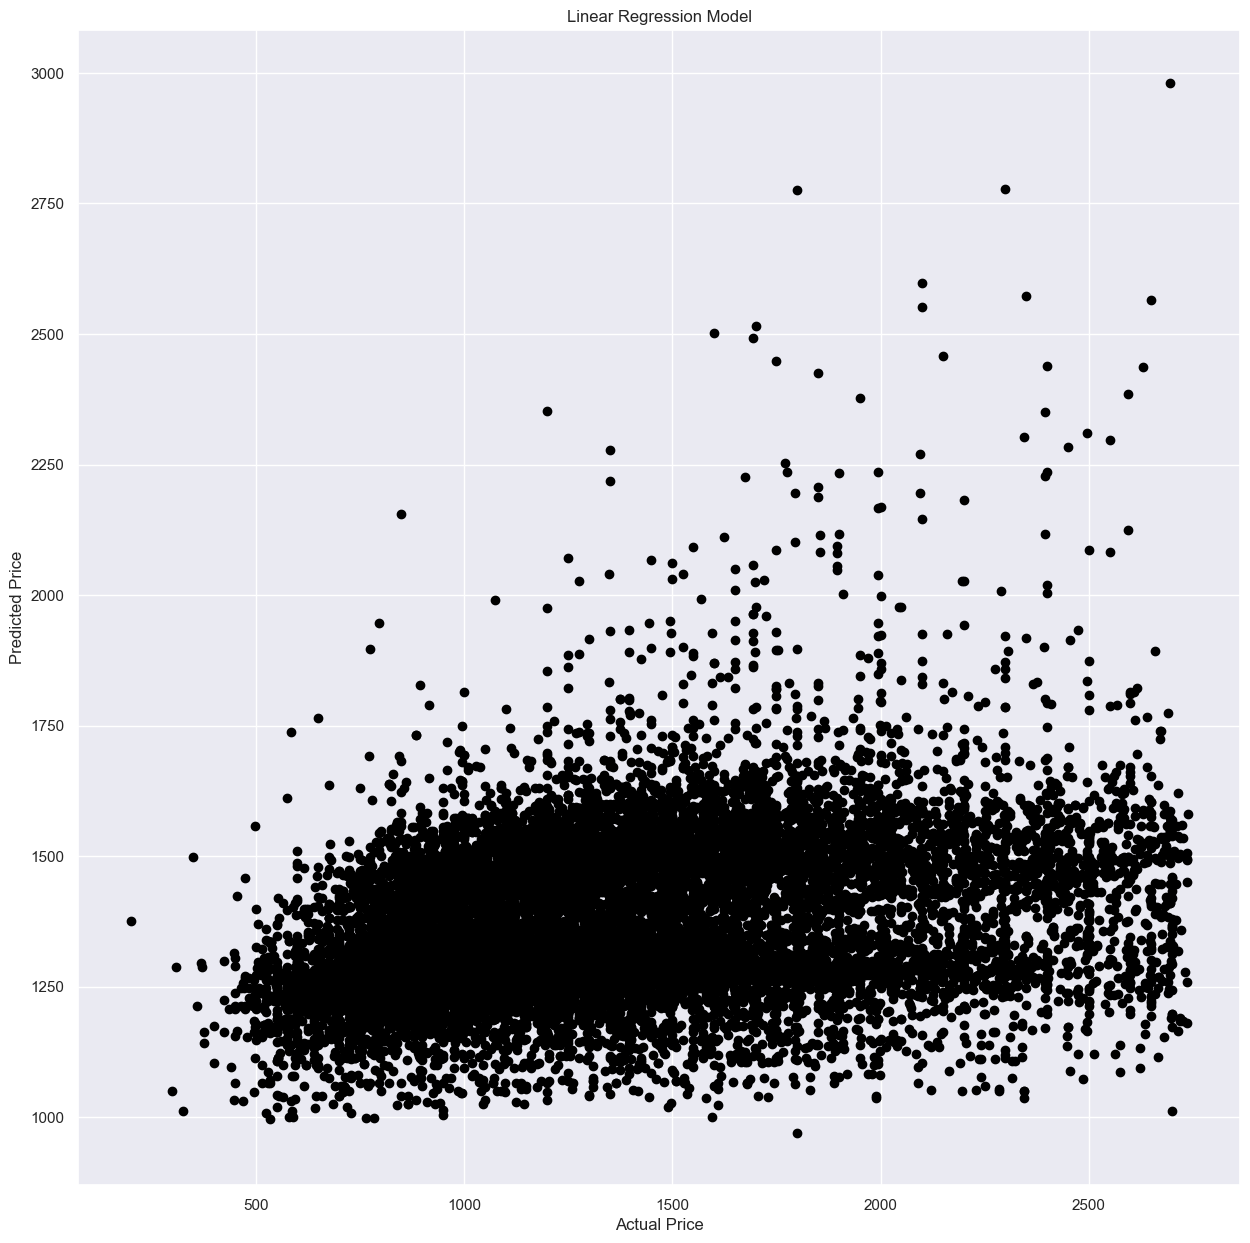

In [18]:
X = data[['bedrooms', 'bathrooms', 'square_feet']]
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2: {r2}')
#show it on graph
plt.scatter(y_test, y_pred, color='black')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression Model')
plt.show()
